In [1]:
#------------------------------------------------------------------------------------------------------------------------
#                  Code Author: Blake Downey
##               Code Title: The Veggie Classifier
###            Course: EEP596 Computer Vision, Classical and Deep Methods
####         Professor: Stan Birchfield
###            Term: Autumn 2021
##               Start Date: 11/21/21
#                  End Date: lmao engineers never conclude their projects
#------------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------------------------------
#                  The Veggie Classifier will begin as a simple project that is extendable if time permits. 
##               This project will incorporate data collection and labeling, a DNN such as ResNeXt or MobileNet,
###            transfer learning, and a plethora of concepts learned through my work in Professor Birchfields 
####         Computer Vision course. 
###            Extensions of this project can include expanding the categories, creating a combination of NNs, and 
##               loading and running the NN on an RPi. These extensions would include more data collection, extended
#                  research on mobilenet and dws convolution and refamiliarizing myself with raspian OS.                  
#------------------------------------------------------------------------------------------------------------------------

In [2]:
#------------------------------------------------------------------------------------------------------------------------
# 
# Import all of the libs I will need for this project
#
#------------------------------------------------------------------------------------------------------------------------

import cv2
import os
import torch
import torchvision 
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import glob #glab for iterating images in diretory
import random
import shutil
import csv
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
#define the classes to be used in the beginning of this project
veggies_v1 = ('bell pepper','broccoli', 'cauliflower', 'cucumber', 'mushroom')
veggies_v2 = ('bell pepper','broccoli', 'cauliflower', 'cucumber', 'mushroom', 'zucchini')

In [4]:
#------------------------------------------------------------------------------------------------------------------------
# Calculate parameter count of ResNet-34
#------------------------------------------------------------------------------------------------------------------------

resnet34 = models.resnet34(pretrained=True)

resnet34_size = 0
for param in resnet34.parameters():
    resnet34_size += param.numel()
print("Parameter count of ResNet34 is %.2fM weights\n" %(resnet34_size/(10**6)))

Parameter count of ResNet34 is 21.80M weights



In [5]:
# directory of original images
original_images = './data/images/'

# directory for cropped images 224x224x3
cropped_folder = './data/c_images/'

# directory for results 
results_folder = './results/'

# two revisions -- v1 and v2
v1 = 'v1/' #15 images / category, no zucchini
v2 = 'v2/' #20 images / category, with zucchini

# directory for the augmented images
augmented_folder = './data/aug_images/'
train_folder = 'train/'
test_folder = 'test/'

# file name for the labeled data
labeled_train_data_csv = 'labeled_train_data.csv'
labeled_test_data_csv = 'labeled_test_data.csv'

# model folders
models_folder = './models/'
resnet34_fc_dir = 'resnet34_fc/'
resnet34_fc_4_dir = 'resnet34_fc_4/'
resnet34_fc_4_3_dir = 'resnet34_fc_4_3/'

# remove and recreate augmented folder
if os.path.isdir(augmented_folder): shutil.rmtree(augmented_folder)
os.mkdir(augmented_folder)
# remove and recreate cropped folder
if os.path.isdir(cropped_folder): shutil.rmtree(cropped_folder)
os.mkdir(cropped_folder)
# remove and recreate models folder
if os.path.isdir(models_folder): shutil.rmtree(models_folder)
os.mkdir(models_folder)
if os.path.isdir(results_folder): shutil.rmtree(results_folder)
os.mkdir(results_folder)
os.mkdir(results_folder + v1)
os.mkdir(results_folder + v2)

def reset_data_v_ws(v):
    # remove the directories if they exist
    if os.path.isdir(augmented_folder + v): shutil.rmtree(augmented_folder + v)
    if os.path.isdir(cropped_folder + v): shutil.rmtree(cropped_folder + v)

    # make the directories cropped and augmented to store images
    os.mkdir(augmented_folder + v)
    os.mkdir(augmented_folder + v + train_folder)
    os.mkdir(augmented_folder + v + test_folder)
    os.mkdir(cropped_folder + v)

def reset_model_v_ws(v):
    # remove the models directory if it exists
    if os.path.isdir(models_folder + v): shutil.rmtree(models_folder + v)
    
    if v == v1:
        # create the directories for the different models
        os.mkdir(models_folder + v)
        os.mkdir(models_folder + v + resnet34_fc_dir)
        os.mkdir(models_folder + v + resnet34_fc_4_dir)
        os.mkdir(models_folder + v + resnet34_fc_4_3_dir)
    if v == v2:
        # create the directories for the different models
        os.mkdir(models_folder + v)
        os.mkdir(models_folder + v + resnet34_fc_4_3_dir)

In [6]:
#------------------------------------------------------------------------------------------------------------------------
# Data Augmentation Functions
# Flip, Flop, Rotate, Scale, Gaussian Noise, Brighten/Darken, Smooth/Sharpen
# Each of the 75 images will have these applied individually, and sequentially 
#------------------------------------------------------------------------------------------------------------------------


#function to resize the images to given square with value hxh
#input takes 1 image and a side value of the desired square image shape
def resizeImageExt(image):
    h,w, _ = image.shape
    short = np.argmin(image.shape[:2])
    if short == 0:
        diff = int((w-h)/2)
        cropped = image[:,diff:w-diff]
    else:
        diff = int((h-w)/2)
        cropped = image[diff:h-diff,:]
    return cropped
    
def resizeImage(image, h): 
    image = resizeImageExt(image) #make the image square hxh or wxw depending on size
    return cv2.resize(image, (h,h), interpolation = cv2.INTER_AREA)

def flip_(image):
        return np.flipud(image)
    
def flop_(image):
    return np.fliplr(image)

def rotate_(image, degree, scale):
    h,w,_ = image.shape
    rot = cv2.getRotationMatrix2D((w/2,h/2), degree,scale)
    return cv2.warpAffine(image,rot,(w,h))

def gaus_(image):
    h,w,c = image.shape
    gauss_noise = np.random.normal(0.0,5,[h,w,c])
    return cv2.add(image, gauss_noise.astype(np.uint8))

def bright_(image):
    bright = np.ones(image.shape, dtype='uint8') * 20
    return cv2.add(image, bright)

def dark_(image):
    dark = np.ones(image.shape, dtype='uint8') * 20
    return cv2.subtract(image, dark)

def smooth_(image):
    smoothing = np.array([[1,1,1],
                                       [1,1,1],
                                       [1,1,1] ])
    smoothing = smoothing/(np.sum(smoothing))
    return cv2.filter2D(image,-1,smoothing)

def sharp_(image):
    sharpening = np.array([[-1,-1,-1],
                                        [-1,9,-1],
                                        [-1,-1,-1] ])
    sharpening = sharpening/(np.sum(sharpening))
    return cv2.filter2D(image,-1,sharpening)

def augment(flip,flop,rot,angle,gaus,bright_dark,smooth_sharp,image):
    #print(flip,flop,rot,angle,gaus,bright_dark,smooth_sharp)
    #gaussian noise
    if gaus == 0: image = gaus_(image)
    #flip
    if flip: image = flip_(image)
    #flop
    if flop: image = flop_(image)
    #rotate
    if rot: image = rotate_(image,angle,1)
    #bright
    if bright_dark == 0: image = bright_(image)
    #dark
    elif bright_dark == 1: image = dark_(image)
    #smooth
    if smooth_sharp == 0 and gaus: image = smooth_(image)
    #sharpen
    elif smooth_sharp == 1 and gaus: image = sharp_(image)
    
    return image


In [7]:
#hyper params
max_epochs = 5 #train for epochs 
batchsize = 4
models_epoch = 3 # models per epoch
images_iteration = batchsize # images per iteration
#images_epoch = train_dataloader.__len__() #images per epoch
augimage_image = 75

##
# x * y * z = S
# 
# x = iterations/model (when to save the model during training)
# y = models/epoch (how many models you want saved per epoch during training)
# z = images/iteration (aka batchsize)
# S = images/epoch (size of training set)
##

In [8]:
#------------------------------------------------------------------------------------------------------------------------
# Generate v1 Data from v1 images
# 15 images per category
# 5 categories {veggies_v1 = ('bell pepper','broccoli', 'cauliflower', 'cucumber', 'mushroom')}
#------------------------------------------------------------------------------------------------------------------------

#call function to delete any preexisting data in v1 augmented images directory
reset_data_v_ws(v1)

images_category = 15 #images per category

count = 0
category = -1
angles = [0,45,90,135,225,270,315]
train_data_to_csv = []
test_data_to_csv = []

#------------------------------------------------------------------------------------------------------------------------
# Loop and crop + augment the images in the original train folder and export to correct augmented folder
#------------------------------------------------------------------------------------------------------------------------

# define the import folder for the input images
import_folder = original_images + v1 + train_folder
# define the export folder for where to put the augmented image 
export_folder = augmented_folder + v1 + train_folder
print('Generating v1 Training Data...')

for img in glob.glob(import_folder + '*.jpg'):

    #------------------------------------------------------------------------------------------------------------------------
    # Read Image in and Crop to Square 224x224x3
    #------------------------------------------------------------------------------------------------------------------------
    name = img[23:] #get the name of the original image
    image = cv2.imread(import_folder + name)
    image = resizeImage(image, 224)
    
    #write the cropped images to the folder just for reference
    cv2.imwrite(cropped_folder + v1 + name, image)
    #also store the image in augmented images
    cv2.imwrite(export_folder + name, image)
    
    #------------------------------------------------------------------------------------------------------------------------
    # Start Augmentation on 'image'
    # 
    # Loop the iterations of augmentation combinations and continuously calling the augment function
    # def augment(flip,flop,rot,angle,gaus,bright_dark,smooth_sharp,image):
    #------------------------------------------------------------------------------------------------------------------------    
    
    if count% int(augimage_image*images_category*.8) == 0: category += 1
        
    train_data_to_csv.append([name, category])

    for i in range(augimage_image):
        temp_name = img[23:len(img)-4] + '_' + str(count) + '.jpg' #generate custom name for each image
        temp_image = augment(round(random.random()),round(random.random()),round(random.random()),
                             angles[round(random.random()*6)],round(random.random()*4),round(random.random()*4),
                             round(random.random()*4),image)
        cv2.imwrite(export_folder + temp_name, temp_image)
        train_data_to_csv.append([temp_name, category])
        count += 1
        
with open(augmented_folder + v1 + labeled_train_data_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(train_data_to_csv)
        
#reset variables
count = 0
category = -1
        
#------------------------------------------------------------------------------------------------------------------------
# Loop and crop + augment the images in the original train folder and export to correct augmented folder
#------------------------------------------------------------------------------------------------------------------------

import_folder = original_images + v1 + test_folder
export_folder = augmented_folder + v1 + test_folder
print('Generating v1 Test Data')
for img in glob.glob(import_folder + '*.jpg'):

    #------------------------------------------------------------------------------------------------------------------------
    # Read Image in and Crop to Square 224x224x3
    #------------------------------------------------------------------------------------------------------------------------
    
    name = img[22:] #get the name of the original image
    image = cv2.imread(import_folder + name)
    image = resizeImage(image, 224)
    
    #write the cropped images to the folder just for reference
    cv2.imwrite(cropped_folder + v1 + name, image)
    #also store the image in augmented images
    cv2.imwrite(export_folder + name, image)
    
    #------------------------------------------------------------------------------------------------------------------------
    # Start Augmentation on 'image'
    # 
    # Loop the iterations of augmentation combinations and continuously calling the augment function
    # def augment(flip,flop,rot,angle,gaus,bright_dark,smooth_sharp,image):
    #------------------------------------------------------------------------------------------------------------------------    
    
    if count% int(augimage_image*images_category*.2) == 0: category += 1
    
    test_data_to_csv.append([name, category])

    for i in range(augimage_image):
        temp_name = img[22:len(img)-4] + '_' + str(count) + '.jpg'
        temp_image = augment(round(random.random()),round(random.random()),round(random.random()),
                             angles[round(random.random()*6)],round(random.random()*4),round(random.random()*4),
                             round(random.random()*4),image)
        cv2.imwrite(export_folder + temp_name, temp_image)
        test_data_to_csv.append([temp_name, category])
        count += 1
    
with open(augmented_folder + v1 + labeled_test_data_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test_data_to_csv)
    
    

# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ***********************************V1 DATA COMPLETED*************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
    
    
#------------------------------------------------------------------------------------------------------------------------
# Generate v2 Data from v2 images
# 20 images per category
# 6 categories {veggies_v2 = ('bell pepper','broccoli', 'cauliflower', 'cucumber', 'mushroom','zucchini')}
#------------------------------------------------------------------------------------------------------------------------

#call function to delete any preexisting data in v1 augmented images directory
reset_data_v_ws(v2)

images_category = 20 #images per category

count = 0
category = -1
train_data_to_csv = []
test_data_to_csv = []

#------------------------------------------------------------------------------------------------------------------------
# Loop and crop + augment the images in the original train folder and export to correct augmented folder
#------------------------------------------------------------------------------------------------------------------------

# define the import folder for the input images
import_folder = original_images + v2 + train_folder
# define the export folder for where to put the augmented image 
export_folder = augmented_folder + v2 + train_folder
print('Generating v2 Training Data...')

for img in glob.glob(import_folder + '*.jpg'):

    #------------------------------------------------------------------------------------------------------------------------
    # Read Image in and Crop to Square 224x224x3
    #------------------------------------------------------------------------------------------------------------------------
    name = img[23:] #get the name of the original image
    image = cv2.imread(import_folder + name)
    image = resizeImage(image, 224)
    
    #write the cropped images to the folder just for reference
    cv2.imwrite(cropped_folder + v2 + name, image)
    #also store the image in augmented images
    cv2.imwrite(export_folder + name, image)
    
    #------------------------------------------------------------------------------------------------------------------------
    # Start Augmentation on 'image'
    # 
    # Loop the iterations of augmentation combinations and continuously calling the augment function
    # def augment(flip,flop,rot,angle,gaus,bright_dark,smooth_sharp,image):
    #------------------------------------------------------------------------------------------------------------------------    
    
    if count% int(augimage_image*images_category*.8) == 0: category += 1
        
    train_data_to_csv.append([name, category])

    for i in range(augimage_image):
        temp_name = img[23:len(img)-4] + '_' + str(count) + '.jpg' #generate custom name for each image
        temp_image = augment(round(random.random()),round(random.random()),round(random.random()),
                             angles[round(random.random()*6)],round(random.random()*4),round(random.random()*4),
                             round(random.random()*4),image)
        cv2.imwrite(export_folder + temp_name, temp_image)
        train_data_to_csv.append([temp_name, category])
        count += 1
        
with open(augmented_folder + v2 + labeled_train_data_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(train_data_to_csv)
        
#reset variables
count = 0
category = -1
        
#------------------------------------------------------------------------------------------------------------------------
# Loop and crop + augment the images in the original train folder and export to correct augmented folder
#------------------------------------------------------------------------------------------------------------------------

import_folder = original_images + v2 + test_folder
export_folder = augmented_folder + v2 + test_folder
print('Generating v2 Test Data')
for img in glob.glob(import_folder + '*.jpg'):

    #------------------------------------------------------------------------------------------------------------------------
    # Read Image in and Crop to Square 224x224x3
    #------------------------------------------------------------------------------------------------------------------------
    
    name = img[22:] #get the name of the original image
    image = cv2.imread(import_folder + name)
    image = resizeImage(image, 224)
    
    #write the cropped images to the folder just for reference
    cv2.imwrite(cropped_folder + v2 + name, image)
    #also store the image in augmented images
    cv2.imwrite(export_folder + name, image)
    
    #------------------------------------------------------------------------------------------------------------------------
    # Start Augmentation on 'image'
    # 
    # Loop the iterations of augmentation combinations and continuously calling the augment function
    # def augment(flip,flop,rot,angle,gaus,bright_dark,smooth_sharp,image):
    #------------------------------------------------------------------------------------------------------------------------    
    
    if count% int(augimage_image*images_category*.2) == 0: category += 1
    
    test_data_to_csv.append([name, category])

    for i in range(augimage_image):
        temp_name = img[22:len(img)-4] + '_' + str(count) + '.jpg'
        temp_image = augment(round(random.random()),round(random.random()),round(random.random()),
                             angles[round(random.random()*6)],round(random.random()*4),round(random.random()*4),
                             round(random.random()*4),image)
        cv2.imwrite(export_folder + temp_name, temp_image)
        test_data_to_csv.append([temp_name, category])
        count += 1
    
with open(augmented_folder + v2 + labeled_test_data_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test_data_to_csv)
    
    
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ***********************************V2 DATA COMPLETED*************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #
# ********************************************************************************************** #


Generating v1 Training Data...
Generating v1 Test Data
Generating v2 Training Data...
Generating v2 Test Data


Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


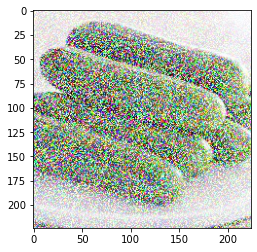

Label: cucumber
Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


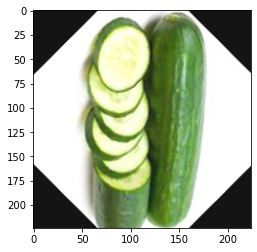

Label: cucumber


In [9]:
#------------------------------------------------------------------------------------------------------------------------
# CustomImageDataset Class Code from PyTorch Website
# Citation for Below Code:
# “Datasets & Dataloaders.” Datasets & DataLoaders - PyTorch Tutorials 1.10.0+cu102 Documentation, 
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html. 
#------------------------------------------------------------------------------------------------------------------------

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#v1 data location
train_loc = augmented_folder + v1 + labeled_train_data_csv
test_loc = augmented_folder + v1 + labeled_test_data_csv
    
# Instantiate Train and Test objects of Class CustomImageDataset -- v1
training_data = CustomImageDataset(train_loc, augmented_folder + v1 + train_folder)
test_data = CustomImageDataset(test_loc, augmented_folder + v1 + test_folder)

# Load train and test classes via DataLoader -- v1
train_dataloader_v1 = DataLoader(training_data, batch_size=batchsize, shuffle=True)
test_dataloader_v1 = DataLoader(test_data, batch_size=batchsize, shuffle=True)

#v2 data location
train_loc = augmented_folder + v2 + labeled_train_data_csv
test_loc = augmented_folder + v2 + labeled_test_data_csv

# Instantiate Train and Test objects of Class CustomImageDataset -- v2
training_data = CustomImageDataset(train_loc, augmented_folder + v2 + train_folder)
test_data = CustomImageDataset(test_loc, augmented_folder + v2 + test_folder)

# Load train and test classes via DataLoader -- v2
train_dataloader_v2 = DataLoader(training_data, batch_size=batchsize, shuffle=True)
test_dataloader_v2 = DataLoader(test_data, batch_size=batchsize, shuffle=True)

# Print a sample image from the training set with the corresponding label
train_features, train_labels = next(iter(train_dataloader_v1))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(np.transpose(img.numpy(), (1,2,0)), cmap="gray")
plt.show()
print(f"Label: {veggies_v1[label]}")


train_features, train_labels = next(iter(train_dataloader_v2))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(np.transpose(img.numpy(), (1,2,0)), cmap="gray")
plt.show()
print(f"Label: {veggies_v2[label]}")

Accuracy for Baseline Method -- v1 by class

bell pepper : 0.00 %
broccoli    : 43.86 %
cauliflower : 57.02 %
cucumber    : 0.88 %
mushroom    : 27.19 %

Total accuracy -- v1: 25.79 %



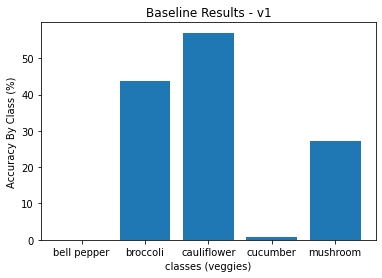

Accuracy for Baseline Method -- v2 by class

bell pepper : 17.82 %
broccoli    : 26.97 %
cauliflower : 5.92 %
cucumber    : 0.66 %
mushroom    : 7.89 %
zucchini    : 60.86 %

Total accuracy -- v2: 20.02 %



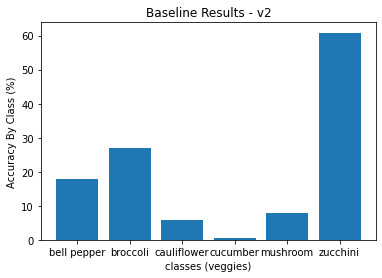

In [10]:
#------------------------------------------------------------------------------------------------------------------------
# Baseline Testing -- v1
## My veggies are chosen to be categories from ImageNet-1000: https://zodoc.tech/posts/en/imagenet_classes 
### The pretrained network I am using here is ResNet-34
## Baseline Results is the total accuracy of the network on my input test data
# This is with no transfer learning, simply using the network as it is pretrained and changing output to 5 classes
#------------------------------------------------------------------------------------------------------------------------

# Import ResNet34 Model
resnet34 = models.resnet34(pretrained=True)
# Change ResNet34 to output 5 classes
resnet34.fc = nn.Linear(in_features=512, out_features=len(veggies_v1), bias=True)

correct_pred_baseline_v1 = {classname: 0 for classname in veggies_v1}
total_pred_baseline_v1 = {classname: 0 for classname in veggies_v1}
total_accuracy_baseline_v1 = 0

acc = []

# BASELINE TESTING
with torch.no_grad():
    for data in test_dataloader_v1:
        images, labels = data
        
        outputs = resnet34(images.float()) #run batch through the netork
        
        _, preds = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred_baseline_v1[veggies_v1[label]] += 1
            total_pred_baseline_v1[veggies_v1[label]] += 1
            
# Print the accuracy of the baseline network by class and total accuracy
print("Accuracy for Baseline Method -- v1 by class\n")
for classname, correct_count in correct_pred_baseline_v1.items():
    accuracy = 100 * float(correct_count) / total_pred_baseline_v1[classname]
    total_accuracy_baseline_v1 += accuracy
    print('{:12s}: {:.2f} %'.format(classname, accuracy))
    acc.append(accuracy)
    
print('\nTotal accuracy -- v1: {:.2f} %\n'.format(total_accuracy_baseline_v1/len(veggies_v1)))

plt.figure()
plt.title("Baseline Results - v1")
plt.ylabel("Accuracy By Class (%)")
plt.xlabel("classes (veggies)")
plt.bar(veggies_v1,acc)
plt.savefig(results_folder + v1 + 'baseline.jpg')
plt.show()

#------------------------------------------------------------------------------------------------------------------------
# Baseline Testing -- v2
# 6 categories / 20 images per category
#------------------------------------------------------------------------------------------------------------------------

# Change ResNet34 to output 5 classes
resnet34.fc = nn.Linear(in_features=512, out_features=len(veggies_v2), bias=True)

correct_pred_baseline_v2 = {classname: 0 for classname in veggies_v2}
total_pred_baseline_v2 = {classname: 0 for classname in veggies_v2}
total_accuracy_baseline_v2 = 0

acc = []

# BASELINE TESTING
with torch.no_grad():
    for data in test_dataloader_v2:
        images, labels = data
        
        outputs = resnet34(images.float()) #run batch through the netork
        
        _, preds = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred_baseline_v2[veggies_v2[label]] += 1
            total_pred_baseline_v2[veggies_v2[label]] += 1
            
# Print the accuracy of the baseline network by class and total accuracy
print("Accuracy for Baseline Method -- v2 by class\n")
for classname, correct_count in correct_pred_baseline_v2.items():
    accuracy = 100 * float(correct_count) / total_pred_baseline_v2[classname]
    total_accuracy_baseline_v2 += accuracy
    print('{:12s}: {:.2f} %'.format(classname, accuracy))
    acc.append(accuracy)
    
print('\nTotal accuracy -- v2: {:.2f} %\n'.format(total_accuracy_baseline_v2/len(veggies_v2)))

plt.figure()
plt.title("Baseline Results - v2")
plt.ylabel("Accuracy By Class (%)")
plt.xlabel("classes (veggies)")
plt.bar(veggies_v2,acc)
plt.savefig(results_folder + v2 + 'baseline.jpg')
plt.show()

In [13]:
#------------------------------------------------------------------------------------------------------------------------
# Define the networks and perform appropriate freezing and unfreezing
#------------------------------------------------------------------------------------------------------------------------

print('Defining ResNet34 retrain models...\n')

# Case 0: ResNet with fc unfrozen
#------------------------------------------------------------------------------------------------------------------------
resnet34_fc = models.resnet34(pretrained=True)
resnet34_fc.fc = nn.Linear(in_features=512, out_features=len(veggies_v1), bias=True)

print('ResNet34 Layer Definition:')

# Print out the structure of ResNet34
for name, child in resnet34_fc.named_children():
    print(name)

print('\nResNet34 ("resnet34_fc") with fc unfrozen:')
    
for name, child in resnet34_fc.named_children():
    if name in ['fc']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else: 
        for param in child.parameters():
            param.requires_grad = False
print('-- all other layers remain frozen\n')
#------------------------------------------------------------------------------------------------------------------------

# Case 1: ResNet with fc and layer4 unfrozen
#------------------------------------------------------------------------------------------------------------------------
print('ResNet34 ("resnet34_fc_4") with fc and layer4 unfrozen:')

resnet34_fc_4 = models.resnet34(pretrained=True)
resnet34_fc_4.fc = nn.Linear(in_features=512, out_features=len(veggies_v1), bias=True)

for name, child in resnet34_fc_4.named_children():
    if name in ['fc', 'layer4']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else: 
        for param in child.parameters():
            param.requires_grad = False
print('-- all other layers remain frozen\n')
#------------------------------------------------------------------------------------------------------------------------

# Case 2: ResNet with fc, layer4 and layer3 unfrozen
#------------------------------------------------------------------------------------------------------------------------
print('ResNet34 ("resnet34_fc_4_3") with fc, layer4 and layer3 unfrozen:')

resnet34_fc_4_3 = models.resnet34(pretrained=True)
resnet34_fc_4_3.fc = nn.Linear(in_features=512, out_features=len(veggies_v1), bias=True)

for name, child in resnet34_fc_4_3.named_children():
    if name in ['fc', 'layer4', 'layer3']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else: 
        for param in child.parameters():
            param.requires_grad = False
print('-- all other layers remain frozen')
#------------------------------------------------------------------------------------------------------------------------

Defining ResNet34 retrain models...

ResNet34 Layer Definition:
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc

ResNet34 ("resnet34_fc") with fc unfrozen:
fc is unfrozen
-- all other layers remain frozen

ResNet34 ("resnet34_fc_4") with fc and layer4 unfrozen:
layer4 is unfrozen
fc is unfrozen
-- all other layers remain frozen

ResNet34 ("resnet34_fc_4_3") with fc, layer4 and layer3 unfrozen:
layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen
-- all other layers remain frozen


In [15]:
#------------------------------------------------------------------------------------------------------------------------
# v1 training
# Transfer Learning with 3 cases: fc unfrozen | fc & layer4 unfrozen | fc & layer4 & layer3 unfrozen 
# Generate Training Error curves for each of the 3 cases with lr = 0.0005 
#------------------------------------------------------------------------------------------------------------------------

# Call this to reset the directories
reset_model_v_ws(v1)

iterations_model = 380 # iterations per model

training_loss = [] #hold the 3 curves for each of the networks with different retraining
criterion = nn.CrossEntropyLoss() #cross entropy loss 

print("Training of ResNet34_fc beginning...")
#------------------------------------------------------------------------------------------------------------------------
temp_loss = [] #temp loss var to hold the running loss values for each case
optimizer = optim.SGD(resnet34_fc.parameters(), lr = 0.0005, momentum = 0.9) #use SGD with momentum

for epoch in range(max_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_v1,0):
        images,labels = data #get the training data
        optimizer.zero_grad() #zero the parameter gradients
        outputs = resnet34_fc(images.float()) #forward pass 
        loss = criterion(outputs, labels) #calc loss
        loss.backward() #backward pass
        optimizer.step() #optimize
        running_loss += loss.item()
        if i % iterations_model == iterations_model-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / iterations_model))
            temp_loss.append(running_loss/iterations_model) #append the running loss to the temp
            running_loss = 0.0
            PATH = models_folder + v1 + resnet34_fc_dir + 'resnet34_fc-' + str(epoch+1) + '-' + str(i+1) + '.pth' #save the path with a unique name
            torch.save(resnet34_fc.state_dict(), PATH) #saved once, dont need to keep saving
            
print("Training of ResNet34_fc completed...\n")
training_loss.append(temp_loss)
#------------------------------------------------------------------------------------------------------------------------

print("Training of ResNet34_fc_4 beginning...")
#------------------------------------------------------------------------------------------------------------------------
temp_loss = [] #temp loss var to hold the running loss values for each case
optimizer = optim.SGD(resnet34_fc_4.parameters(), lr = 0.0005, momentum = 0.9) #use SGD with momentum

for epoch in range(max_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_v1,0):
        images,labels = data #get the training data
        optimizer.zero_grad() #zero the parameter gradients
        outputs = resnet34_fc_4(images.float()) #forward pass 
        loss = criterion(outputs, labels) #calc loss
        loss.backward() #backward pass
        optimizer.step() #optimize
        running_loss += loss.item()
        if i % iterations_model == iterations_model-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / iterations_model))
            temp_loss.append(running_loss/iterations_model) #append the running loss to the temp
            running_loss = 0.0
            PATH = models_folder + v1 + resnet34_fc_4_dir + 'resnet34_fc_4-' + str(epoch+1) + '-' + str(i+1) + '.pth' #save the path with a unique name
            torch.save(resnet34_fc_4.state_dict(), PATH) #saved once, dont need to keep saving
            
print("Training of ResNet34_fc_4 completed...\n")
training_loss.append(temp_loss)
#------------------------------------------------------------------------------------------------------------------------

print("Training of ResNet34_fc_4_3 beginning...")
#------------------------------------------------------------------------------------------------------------------------
temp_loss = [] #temp loss var to hold the running loss values for each case
optimizer = optim.SGD(resnet34_fc_4_3.parameters(), lr = 0.0005, momentum = 0.9) #use SGD with momentum

for epoch in range(max_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_v1,0):
        images,labels = data #get the training data
        optimizer.zero_grad() #zero the parameter gradients
        outputs = resnet34_fc_4_3(images.float()) #forward pass 
        loss = criterion(outputs, labels) #calc loss
        loss.backward() #backward pass
        optimizer.step() #optimize
        running_loss += loss.item()
        if i % iterations_model == iterations_model-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / iterations_model))
            temp_loss.append(running_loss/iterations_model) #append the running loss to the temp
            running_loss = 0.0
            PATH = models_folder + v1 + resnet34_fc_4_3_dir + 'resnet34_fc_4_3-' + str(epoch+1) + '-' + str(i+1) + '.pth' #save the path with a unique name
            torch.save(resnet34_fc_4_3.state_dict(), PATH) #saved once, dont need to keep saving
            
print("Training of ResNet34_fc_4_3 completed...\n")
training_loss.append(temp_loss)
#------------------------------------------------------------------------------------------------------------------------

Training of ResNet34_fc beginning...
[1,   380] loss: 0.449
[1,   760] loss: 0.382
[1,  1140] loss: 0.372
[2,   380] loss: 0.329
[2,   760] loss: 0.304
[2,  1140] loss: 0.314
[3,   380] loss: 0.260
[3,   760] loss: 0.275
[3,  1140] loss: 0.287
[4,   380] loss: 0.254
[4,   760] loss: 0.270
[4,  1140] loss: 0.266
[5,   380] loss: 0.249
[5,   760] loss: 0.277
[5,  1140] loss: 0.284
Training of ResNet34_fc completed...

Training of ResNet34_fc_4 beginning...
[1,   380] loss: 0.527
[1,   760] loss: 0.280
[1,  1140] loss: 0.191
[2,   380] loss: 0.157
[2,   760] loss: 0.134
[2,  1140] loss: 0.126
[3,   380] loss: 0.113
[3,   760] loss: 0.102
[3,  1140] loss: 0.097
[4,   380] loss: 0.098
[4,   760] loss: 0.077
[4,  1140] loss: 0.061
[5,   380] loss: 0.046
[5,   760] loss: 0.054
[5,  1140] loss: 0.048
Training of ResNet34_fc_4 completed...

Training of ResNet34_fc_4_3 beginning...
[1,   380] loss: 0.460
[1,   760] loss: 0.219
[1,  1140] loss: 0.145
[2,   380] loss: 0.106
[2,   760] loss: 0.100


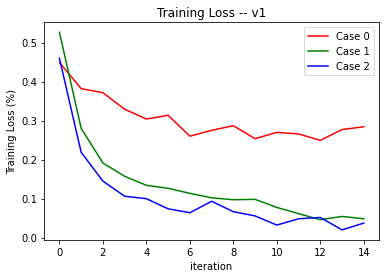

In [16]:
# Training Loss

#plot the training loss
plt.figure
plt.title("Training Loss -- v1")
plt.ylabel("Training Loss (%)")
plt.xlabel("iteration")
plt.plot(training_loss[0], color='red', label='Case 0')    # resnet34_fc
plt.plot(training_loss[1], color='green', label='Case 1') # resnet34_fc_4
plt.plot(training_loss[2], color='blue', label='Case 2')   # resnet34_fc_4_3
leg = plt.legend(loc='upper right')
plt.savefig(results_folder + v1 + 'trainingloss.jpg')
plt.show()


Testing of ResNet34_fc -- v1 beginning...
./models/v1/resnet34_fc/resnet34_fc-5-1140.pth
Accuracy for Case 0 -- v1 by class
bell pepper : 80.62 %
broccoli    : 73.68 %
cauliflower : 77.19 %
cucumber    : 94.30 %
mushroom    : 92.54 %
Testing of ResNet34_fc completed...Total accuracy -- v1: 83.67 %



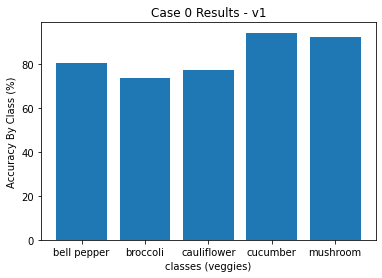


Testing of ResNet34_fc_4 -- v1 beginning...
./models/v1/resnet34_fc_4/resnet34_fc_4-5-1140.pth
Accuracy for Case 1 -- v1 by class
bell pepper : 75.77 %
broccoli    : 93.42 %
cauliflower : 85.53 %
cucumber    : 89.04 %
mushroom    : 98.25 %
Testing of ResNet34_fc_4 completed...Total accuracy -- v1: 88.40 %



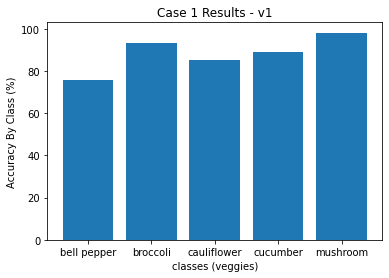


Testing of ResNet34_fc_4_3 -- v1 beginning...
./models/v1/resnet34_fc_4_3/resnet34_fc_4_3-5-1140.pth
Accuracy for Case 2 -- v1 by class
bell pepper : 87.67 %
broccoli    : 93.86 %
cauliflower : 92.11 %
cucumber    : 96.93 %
mushroom    : 98.68 %
Testing of ResNet34_fc_4_3 completed...Total accuracy -- v1: 93.85 %



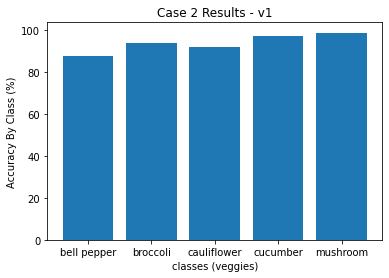

In [17]:
# Test Error -- v1

#------------------------------------------------------------------------------------------------------------------------
# Fully Trained Accuracy for comparison with Baseline Accuracy -- v1
#------------------------------------------------------------------------------------------------------------------------

# Testing on ResNet34_fc
print("Testing of ResNet34_fc -- v1 beginning...")
#------------------------------------------------------------------------------------------------------------------------
correct_pred_fc = {classname: 0 for classname in veggies_v1}
total_pred_fc = {classname: 0 for classname in veggies_v1}
total_accuracy_fc = 0
acc = []

# load the network with the fully trained model
PATH = models_folder + v1 + resnet34_fc_dir + 'resnet34_fc-'+str(max_epochs)+'-'+str(iterations_model*models_epoch)+'.pth'
print(PATH)
resnet34_fc.load_state_dict(torch.load(PATH))

# ResNet34_fc fully trained single value accuracy results
with torch.no_grad():
    for data in test_dataloader_v1:
        
        images, labels = data
        outputs = resnet34_fc(images.float()) #run batch through the netork
        _, preds = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred_fc[veggies_v1[label]] += 1
            total_pred_fc[veggies_v1[label]] += 1
            
# Print the accuracy of the baseline network by class and total accuracy
print("Accuracy for Case 0 -- v1 by class")
for classname, correct_count in correct_pred_fc.items():
    accuracy = 100 * float(correct_count) / total_pred_fc[classname]
    total_accuracy_fc += accuracy
    print('{:12s}: {:.2f} %'.format(classname, accuracy))
    acc.append(accuracy)
    
print('Testing of ResNet34_fc completed...Total accuracy -- v1: {:.2f} %\n'.format(total_accuracy_fc/len(veggies_v1)))
#------------------------------------------------------------------------------------------------------------------------

plt.figure()
plt.title("Case 0 Results - v1")
plt.ylabel("Accuracy By Class (%)")
plt.xlabel("classes (veggies)")
plt.bar(veggies_v1,acc)
plt.savefig(results_folder + v1 + 'case0.jpg')
plt.show()

# Testing on ResNet34_fc_4
print("\nTesting of ResNet34_fc_4 -- v1 beginning...")
#------------------------------------------------------------------------------------------------------------------------
correct_pred_fc_4 = {classname: 0 for classname in veggies_v1}
total_pred_fc_4 = {classname: 0 for classname in veggies_v1}
total_accuracy_fc_4 = 0
acc = []

# load the network with the fully trained model
PATH = models_folder + v1 + resnet34_fc_4_dir + 'resnet34_fc_4-'+str(max_epochs)+'-'+str(iterations_model*models_epoch)+'.pth'
print(PATH)
resnet34_fc_4.load_state_dict(torch.load(PATH))

# ResNet34_fc fully trained single value accuracy results
with torch.no_grad():
    for data in test_dataloader_v1:
        
        images, labels = data
        outputs = resnet34_fc_4(images.float()) #run batch through the netork
        _, preds = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred_fc_4[veggies_v1[label]] += 1
            total_pred_fc_4[veggies_v1[label]] += 1
            
# Print the accuracy of the baseline network by class and total accuracy
print("Accuracy for Case 1 -- v1 by class")
for classname, correct_count in correct_pred_fc_4.items():
    accuracy = 100 * float(correct_count) / total_pred_fc_4[classname]
    total_accuracy_fc_4 += accuracy
    print('{:12s}: {:.2f} %'.format(classname, accuracy))
    acc.append(accuracy)
    
print('Testing of ResNet34_fc_4 completed...Total accuracy -- v1: {:.2f} %\n'.format(total_accuracy_fc_4/len(veggies_v1)))
#------------------------------------------------------------------------------------------------------------------------

plt.figure()
plt.title("Case 1 Results - v1")
plt.ylabel("Accuracy By Class (%)")
plt.xlabel("classes (veggies)")
plt.bar(veggies_v1,acc)
plt.savefig(results_folder + v1 + 'case1.jpg')
plt.show()

# Testing on ResNet34_fc_4_3
print("\nTesting of ResNet34_fc_4_3 -- v1 beginning...")
#------------------------------------------------------------------------------------------------------------------------
correct_pred_fc_4_3 = {classname: 0 for classname in veggies_v1}
total_pred_fc_4_3 = {classname: 0 for classname in veggies_v1}
total_accuracy_fc_4_3 = 0
acc = []

# load the network with the fully trained model
PATH = models_folder + v1 + resnet34_fc_4_3_dir + 'resnet34_fc_4_3-'+str(max_epochs)+'-'+str(iterations_model*models_epoch)+'.pth'
print(PATH)
resnet34_fc_4_3.load_state_dict(torch.load(PATH))

# ResNet34_fc fully trained single value accuracy results
with torch.no_grad():
    for data in test_dataloader_v1:
        
        images, labels = data
        outputs = resnet34_fc_4_3(images.float()) #run batch through the netork
        _, preds = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred_fc_4_3[veggies_v1[label]] += 1
            total_pred_fc_4_3[veggies_v1[label]] += 1
            
# Print the accuracy of the baseline network by class and total accuracy
print("Accuracy for Case 2 -- v1 by class")
for classname, correct_count in correct_pred_fc_4_3.items():
    accuracy = 100 * float(correct_count) / total_pred_fc_4_3[classname]
    total_accuracy_fc_4_3 += accuracy
    print('{:12s}: {:.2f} %'.format(classname, accuracy))
    acc.append(accuracy)
    
print('Testing of ResNet34_fc_4_3 completed...Total accuracy -- v1: {:.2f} %\n'.format(total_accuracy_fc_4_3/len(veggies_v1)))
#------------------------------------------------------------------------------------------------------------------------

plt.figure()
plt.title("Case 2 Results - v1")
plt.ylabel("Accuracy By Class (%)")
plt.xlabel("classes (veggies)")
plt.bar(veggies_v1,acc)
plt.savefig(results_folder + v1 + 'case2.jpg')
plt.show()

Running input data on each model step... ResNet34_fc...v1
model: ./models/v1/resnet34_fc/resnet34_fc-1-380.pth
model: ./models/v1/resnet34_fc/resnet34_fc-1-760.pth
model: ./models/v1/resnet34_fc/resnet34_fc-1-1140.pth
model: ./models/v1/resnet34_fc/resnet34_fc-2-380.pth
model: ./models/v1/resnet34_fc/resnet34_fc-2-760.pth
model: ./models/v1/resnet34_fc/resnet34_fc-2-1140.pth
model: ./models/v1/resnet34_fc/resnet34_fc-3-380.pth
model: ./models/v1/resnet34_fc/resnet34_fc-3-760.pth
model: ./models/v1/resnet34_fc/resnet34_fc-3-1140.pth
model: ./models/v1/resnet34_fc/resnet34_fc-4-380.pth
model: ./models/v1/resnet34_fc/resnet34_fc-4-760.pth
model: ./models/v1/resnet34_fc/resnet34_fc-4-1140.pth
model: ./models/v1/resnet34_fc/resnet34_fc-5-380.pth
model: ./models/v1/resnet34_fc/resnet34_fc-5-760.pth
model: ./models/v1/resnet34_fc/resnet34_fc-5-1140.pth
Completed... ResNet34_fc...v1
Running input data on each model step... ResNet34_fc_4...v1
model: ./models/v1/resnet34_fc_4/resnet34_fc_4-1-380

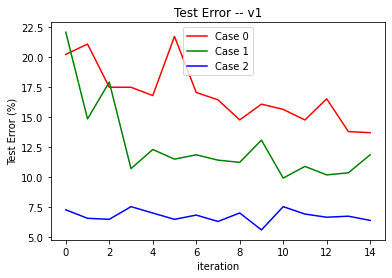

In [18]:
# Test Error cont...

#------------------------------------------------------------------------------------------------------------------------
# Test-Error curves for each case
#------------------------------------------------------------------------------------------------------------------------

test_error = []

print("Running input data on each model step... ResNet34_fc...v1")
#------------------------------------------------------------------------------------------------------------------------
epoch = 1
i = 0
temp_error = []

for j in range(models_epoch*max_epochs): #models per learning rate
    correct_pred = {classname: 0 for classname in veggies_v1}
    total_pred = {classname: 0 for classname in veggies_v1}
    total_accuracy = 0
    i+=iterations_model
    PATH = models_folder + v1 + resnet34_fc_dir + 'resnet34_fc-' + str(epoch) + '-' + str(i) + '.pth'
    print("model: " + PATH)
    resnet34_fc.load_state_dict(torch.load(PATH)) #use torch.load to load the state_dict to created net
    if i == iterations_model*models_epoch:
        epoch += 1
        i = 0
    with torch.no_grad():
        for data in test_dataloader_v1: #ensure to load the testloader images this time
            
            images, labels = data
            outputs = resnet34_fc(images.float())
            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[veggies_v1[label]] += 1
                total_pred[veggies_v1[label]] += 1

    for classname, correct_count in correct_pred.items():
        total_accuracy += 100 * float(correct_count) / total_pred[classname]
    temp_error.append(100 - (total_accuracy/len(veggies_v1)))
test_error.append(temp_error) #append to test error to accumulate the data to plot
#------------------------------------------------------------------------------------------------------------------------
print("Completed... ResNet34_fc...v1")

print("Running input data on each model step... ResNet34_fc_4...v1")
#------------------------------------------------------------------------------------------------------------------------
epoch = 1
i = 0
temp_error = []

for j in range(models_epoch*max_epochs): #models per learning rate
    correct_pred = {classname: 0 for classname in veggies_v1}
    total_pred = {classname: 0 for classname in veggies_v1}
    total_accuracy = 0
    i+=iterations_model
    PATH = models_folder + v1 + resnet34_fc_4_dir + 'resnet34_fc_4-' + str(epoch) + '-' + str(i) + '.pth'
    print("model: " + PATH)
    resnet34_fc_4.load_state_dict(torch.load(PATH)) #use torch.load to load the state_dict to created net
    if i == iterations_model*models_epoch:
        epoch += 1
        i = 0
    with torch.no_grad():
        for data in test_dataloader_v1: #ensure to load the testloader images this time
            
            images, labels = data
            outputs = resnet34_fc_4(images.float())
            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[veggies_v1[label]] += 1
                total_pred[veggies_v1[label]] += 1

    for classname, correct_count in correct_pred.items():
        total_accuracy += 100 * float(correct_count) / total_pred[classname]
    temp_error.append(100 - (total_accuracy/len(veggies_v1)))
test_error.append(temp_error) #append to test error to accumulate the data to plot
#------------------------------------------------------------------------------------------------------------------------
print("Completed... ResNet34_fc_4...v1")

print("Running input data on each model step... ResNet34_fc_4_3...v1")
#------------------------------------------------------------------------------------------------------------------------
epoch = 1
i = 0
temp_error = []

for j in range(models_epoch*max_epochs): #models per learning rate
    correct_pred = {classname: 0 for classname in veggies_v1}
    total_pred = {classname: 0 for classname in veggies_v1}
    total_accuracy = 0
    i+=iterations_model
    PATH = models_folder + v1 + resnet34_fc_4_3_dir + 'resnet34_fc_4_3-' + str(epoch) + '-' + str(i) + '.pth'
    print("model: " + PATH)
    resnet34_fc.load_state_dict(torch.load(PATH)) #use torch.load to load the state_dict to created net
    if i == iterations_model*models_epoch:
        epoch += 1
        i = 0
    with torch.no_grad():
        for data in test_dataloader_v1: #ensure to load the testloader images this time
            
            images, labels = data
            outputs = resnet34_fc_4_3(images.float())
            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[veggies_v1[label]] += 1
                total_pred[veggies_v1[label]] += 1

    for classname, correct_count in correct_pred.items():
        total_accuracy += 100 * float(correct_count) / total_pred[classname]
    temp_error.append(100 - (total_accuracy/len(veggies_v1)))
test_error.append(temp_error) #append to test error to accumulate the data to plot
#------------------------------------------------------------------------------------------------------------------------
print("Completed... ResNet34_fc_4_3...v1")


#plot the test error
plt.figure
plt.title("Test Error -- v1")
plt.ylabel("Test Error (%)")
plt.xlabel("iteration")
plt.plot(test_error[0], color='red', label='Case 0')    # resnet34_fc
plt.plot(test_error[1], color='green', label='Case 1') # resnet34_fc_4
plt.plot(test_error[2], color='blue', label='Case 2')   # resnet34_fc_4_3
leg = plt.legend(loc='upper center')
plt.savefig(results_folder + v1 + 'testerror.jpg')
plt.show()


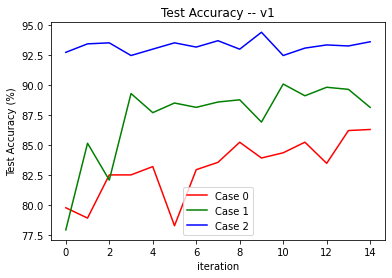

In [19]:
test_accuracy = []
for err in test_error:
    acc = []
    for e in err:
        acc.append(100-e)
    test_accuracy.append(acc)
    
#plot the test accuracy
plt.figure
plt.title("Test Accuracy -- v1")
plt.ylabel("Test Accuracy (%)")
plt.xlabel("iteration")
plt.plot(test_accuracy[0], color='red', label='Case 0')    # resnet34_fc
plt.plot(test_accuracy[1], color='green', label='Case 1') # resnet34_fc_4
plt.plot(test_accuracy[2], color='blue', label='Case 2')   # resnet34_fc_4_3
leg = plt.legend(loc='lower center')
plt.savefig(results_folder + v1 + 'testaccuracy.jpg')
plt.show()

ResNet34 ("resnet34_fc_4_3") with fc, layer4 and layer3 unfrozen:
layer3 is unfrozen
layer4 is unfrozen
fc is unfrozen
-- all other layers remain frozen

Training of ResNet34_fc_4_3 beginning...
[1,   608] loss: 0.533
[1,  1216] loss: 0.262
[1,  1824] loss: 0.163
[2,   608] loss: 0.095
[2,  1216] loss: 0.092
[2,  1824] loss: 0.090
[3,   608] loss: 0.075
[3,  1216] loss: 0.074
[3,  1824] loss: 0.054
[4,   608] loss: 0.059
[4,  1216] loss: 0.057
[4,  1824] loss: 0.041
[5,   608] loss: 0.035
[5,  1216] loss: 0.028
[5,  1824] loss: 0.031
Training of ResNet34_fc_4_3 completed...



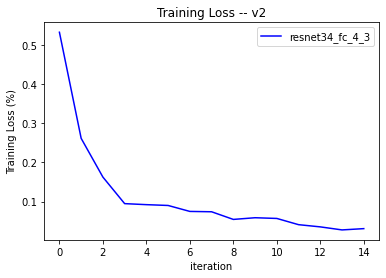


Testing of ResNet34_fc_4_3 -- v2 beginning...
./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-5-1824.pth
Accuracy for Case 2 -- v2 by class
bell pepper : 84.49 %
broccoli    : 94.74 %
cauliflower : 97.37 %
cucumber    : 61.84 %
mushroom    : 99.67 %
zucchini    : 90.13 %
Testing of ResNet34_fc_4_3 completed...Total accuracy -- v2: 88.04 %



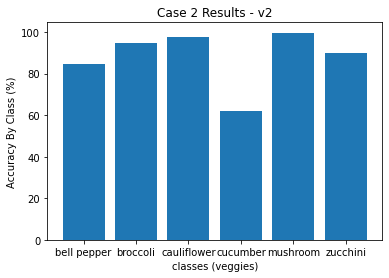

In [26]:
# v2 set up and training

# Use this case since it performed the best -- redefine for v2 training
#------------------------------------------------------------------------------------------------------------------------
print('ResNet34 ("resnet34_fc_4_3") with fc, layer4 and layer3 unfrozen:')

resnet34_fc_4_3 = models.resnet34(pretrained=True)
resnet34_fc_4_3.fc = nn.Linear(in_features=512, out_features=len(veggies_v2), bias=True)

for name, child in resnet34_fc_4_3.named_children():
    if name in ['fc', 'layer4', 'layer3']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else: 
        for param in child.parameters():
            param.requires_grad = False
print('-- all other layers remain frozen')
#------------------------------------------------------------------------------------------------------------------------


#------------------------------------------------------------------------------------------------------------------------
# v2 training
# Transfer Learning with 1 case: fc & layer4 & layer3 unfrozen 
# Generate Training Error curve with lr = 0.0005 
#------------------------------------------------------------------------------------------------------------------------

# Call this to reset the directories
reset_model_v_ws(v2)

iterations_model = 608 # iterations per model
criterion = nn.CrossEntropyLoss() #cross entropy loss 

print("\nTraining of ResNet34_fc_4_3 beginning...")
#------------------------------------------------------------------------------------------------------------------------
train_loss = [] #temp loss var to hold the running loss values for each case
optimizer = optim.SGD(resnet34_fc_4_3.parameters(), lr = 0.0005, momentum = 0.9) #use SGD with momentum

for epoch in range(max_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_v2,0):
        images,labels = data #get the training data
        optimizer.zero_grad() #zero the parameter gradients
        outputs = resnet34_fc_4_3(images.float()) #forward pass 
        loss = criterion(outputs, labels) #calc loss
        loss.backward() #backward pass
        optimizer.step() #optimize
        running_loss += loss.item()
        if i % iterations_model == iterations_model-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / iterations_model))
            train_loss.append(running_loss/iterations_model) #append the running loss to the temp
            running_loss = 0.0
            PATH = models_folder + v2 + resnet34_fc_4_3_dir + 'resnet34_fc_4_3-' + str(epoch+1) + '-' + str(i+1) + '.pth' #save the path with a unique name
            torch.save(resnet34_fc_4_3.state_dict(), PATH) #saved once, dont need to keep saving
            
print("Training of ResNet34_fc_4_3 completed...\n")

#plot the training loss
plt.figure
plt.title("Training Loss -- v2")
plt.ylabel("Training Loss (%)")
plt.xlabel("iteration")
plt.plot(train_loss, color='blue', label='resnet34_fc_4_3')    # resnet34_fc_4_3
leg = plt.legend(loc='upper right')
plt.savefig(results_folder + v2 + 'trainingloss.jpg')
plt.show()
#------------------------------------------------------------------------------------------------------------------------


# Testing on ResNet34_fc_4_3
print("\nTesting of ResNet34_fc_4_3 -- v2 beginning...")
#------------------------------------------------------------------------------------------------------------------------
correct_pred_fc_4_3 = {classname: 0 for classname in veggies_v2}
total_pred_fc_4_3 = {classname: 0 for classname in veggies_v2}
total_accuracy_fc_4_3 = 0
acc = []

# load the network with the fully trained model
PATH = models_folder + v2 + resnet34_fc_4_3_dir + 'resnet34_fc_4_3-'+str(max_epochs)+'-'+str(iterations_model*models_epoch)+'.pth'
print(PATH)
resnet34_fc_4_3.load_state_dict(torch.load(PATH))

# ResNet34_fc fully trained single value accuracy results
with torch.no_grad():
    for data in test_dataloader_v2:
        
        images, labels = data
        outputs = resnet34_fc_4_3(images.float()) #run batch through the netork
        _, preds = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred_fc_4_3[veggies_v2[label]] += 1
            total_pred_fc_4_3[veggies_v2[label]] += 1
            
# Print the accuracy of the baseline network by class and total accuracy
print("Accuracy for Case 2 -- v2 by class")
for classname, correct_count in correct_pred_fc_4_3.items():
    accuracy = 100 * float(correct_count) / total_pred_fc_4_3[classname]
    total_accuracy_fc_4_3 += accuracy
    print('{:12s}: {:.2f} %'.format(classname, accuracy))
    acc.append(accuracy)
    
print('Testing of ResNet34_fc_4_3 completed...Total accuracy -- v2: {:.2f} %\n'.format(total_accuracy_fc_4_3/len(veggies_v2)))
#------------------------------------------------------------------------------------------------------------------------

plt.figure()
plt.title("Case 2 Results - v2")
plt.ylabel("Accuracy By Class (%)")
plt.xlabel("classes (veggies)")
plt.bar(veggies_v2,acc)
plt.savefig(results_folder + v2 + 'case2.jpg')
plt.show()




Running input data on each model step... ResNet34_fc_4_3...
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-1-608.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-1-1216.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-1-1824.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-2-608.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-2-1216.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-2-1824.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-3-608.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-3-1216.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-3-1824.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-4-608.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-4-1216.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-4-1824.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-5-608.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-5-1216.pth
model: ./models/v2/resnet34_fc_4_3/resnet34_fc_4_3-5-1824.pth
Completed... Re

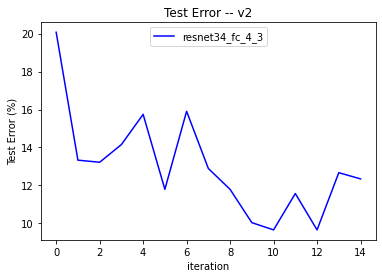

In [27]:
print("Running input data on each model step... ResNet34_fc_4_3...")
#------------------------------------------------------------------------------------------------------------------------
epoch = 1
i = 0
test_error_v2 = []

for j in range(models_epoch*max_epochs): #models per learning rate
    correct_pred = {classname: 0 for classname in veggies_v2}
    total_pred = {classname: 0 for classname in veggies_v2}
    total_accuracy = 0
    i+=iterations_model
    PATH = models_folder + v2 + resnet34_fc_4_3_dir + 'resnet34_fc_4_3-' + str(epoch) + '-' + str(i) + '.pth'
    print("model: " + PATH)
    resnet34_fc_4_3.load_state_dict(torch.load(PATH)) #use torch.load to load the state_dict to created net
    if i == iterations_model*models_epoch:
        epoch += 1
        i = 0
    with torch.no_grad():
        for data in test_dataloader_v2: #ensure to load the testloader images this time
            
            images, labels = data
            outputs = resnet34_fc_4_3(images.float())
            _, preds = torch.max(outputs, 1)

            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[veggies_v2[label]] += 1
                total_pred[veggies_v2[label]] += 1

    for classname, correct_count in correct_pred.items():
        total_accuracy += 100 * float(correct_count) / total_pred[classname]
    test_error_v2.append(100 - (total_accuracy/len(veggies_v2)))
#------------------------------------------------------------------------------------------------------------------------
print("Completed... ResNet34_fc_4_3...")

#plot the test error
plt.figure
plt.title("Test Error -- v2")
plt.ylabel("Test Error (%)")
plt.xlabel("iteration")
plt.plot(test_error_v2, color='blue', label='resnet34_fc_4_3')   # resnet34_fc_4_3
leg = plt.legend(loc='upper center')
plt.savefig(results_folder + v2 + 'testerror.jpg')
plt.show()
    
    
    


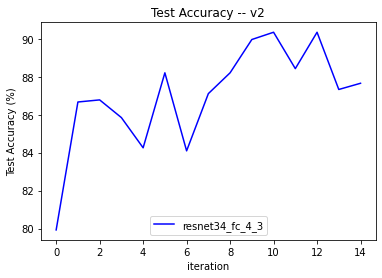

In [28]:
test_accuracy_2 = []
for err in test_error_v2:
    test_accuracy_2.append(100-err)
#plot the test accuracy
plt.figure
plt.title("Test Accuracy -- v2")
plt.ylabel("Test Accuracy (%)")
plt.xlabel("iteration")
plt.plot(test_accuracy_2, color='blue', label='resnet34_fc_4_3')   # resnet34_fc_4_3
leg = plt.legend(loc='lower center')
plt.savefig(results_folder + v2 + 'testaccuracy.jpg')
plt.show()